# 一维Euler方程
$$\frac{\partial\rm{U}}{\partial t}+\frac{\rm{f}(\rm{U})}{\partial x}=0\qquad\rm{U}=\begin{bmatrix}\rho\\\rho u\\E\end{bmatrix},\rm{f}(\rm{U})=\begin{bmatrix}\rho u\\\rho u^2+p\\u(E+p)\end{bmatrix}$$
- Sod激波管问题：$x\in [0, 1]$，$t=0$时
$$(p,u,\rho)=\begin{cases}1,0,1& x<0.5\\0.1,0,0.125& x\le 0.5\end{cases} $$
- Shu-Osher问题：$x\in [0, 10]$，$t=0$时
$$\begin{cases}\rho=3.857143,u=2.629369,p=10.333333&x<1\\\rho=1+A\sin(\omega x),u=0,p=1&x\le 1\end{cases}$$
  其中$A=0.2$，$\omega=0.5$。

In [18]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

plt.rc('text', usetex=True)

## 激波捕捉格式
- 参考：李新亮，《计算流体力学》课件 (PPT) 第 4 讲
### TVD

## 通量分裂技术：模型方程=>NS/Euler方程
- 参考
  - 李新亮，《计算流体力学》课件 (PPT) 第 5 讲
  - Toro, E. F. (2009). Riemann solvers and numerical methods for fluid dynamics: A practical introduction (3rd ed.). Springer Science & Business Media. https://doi.org/10.1007/b79761
### 流通矢量分裂
不清楚扰动传播方向：分成正向传播的和负向传播的。
$$\rm{f}(\rm{U})=\rm{f}^+(\rm{U})+\rm{f}^-(\rm{U}) $$
- Steger-Warming
- Lax-Friedrichs
- Van Leer
- 特征重构
### 通量差分分裂
- Roe

In [ ]:
def steger_warming_splitting(rho, u, p, c):
    pass

In [46]:
def init_value(nx, init_type):
    '''
    Generate initial values.
    =========================
    input: nx: gird number
           init_type: Sod or Shu-Osher problem
    output: Q: conservative variable, (3,nx)
            x: coordinate, 1*nx
    '''
    gamma = 1.4
    init_sod = 0          # Sod problem
    init_shu_osher = 1    # Shu-Osher problem
    Q = np.zeros((3, nx)) # conservative variable
    if init_type == init_sod:
        dx = 1 / (nx - 1)
        x = np.array([i*dx for i in range(nx)]) # x in [0, 1]
        rho1 = 1; u1 = 0; p1 = 1
        rho2 = 0.1; u2 = 0; p2 = 0.125
        Q[0, :int(nx/2)] = rho1 
        Q[1, :int(nx/2)] = rho1*u1 
        Q[2, :int(nx/2)] = p1/(gamma-1) + rho1*u1*u1/2 
        Q[0, int(nx/2):] = rho2
        Q[1, int(nx/2):] = rho2*u2
        Q[2, int(nx/2):] = p2/(gamma-1) + rho2*u2*u2/2
    else:
        dx = 10 / (nx - 1)
        x = np.array([i*dx for i in range(nx)]) # x in [0, 10]
        rho1 = 3.857143; u1 = 2.629369; p1 = 10.333333
        u2 = 0; p2 = 1
        Q[0, :] = 1 + 0.2*np.sin(5*x)
        Q[0, :int(nx/10)] = rho1
        Q[1, :] = (1 + 0.2*np.sin(5*x))*u2
        Q[1, :int(nx/10)] = rho1*u1
        Q[2, :] = p2/(gamma-1) + (1 + 0.2*np.sin(5*x))*u2*u2/2
        Q[2, :int(nx/10)] = p1/(gamma-1) + rho1*u1*u1/2

    return Q, x

def primitive_var(Q):
    '''
    Transfer conservative variables into primitive variables.
    =========================================================
    input: Q: conservative variables, (3,nx)
    output: rho, u, p, c: density, velocity, pressure, sound speed, respectively, (nx,)
    '''
    rho = Q[0, :];
    u = Q[1, :]/Q[0, :]
    p = (gamma-1)*(Q[2,:]-Q[1,:]*u/2)
    c = np.sqrt(gamma*p/rho)

    return rho, u, p, c

(1, 21)

## Riemann问题精确解
- 参考：李新亮，《计算流体力学》课件 (PPT) 第 2 讲

In [15]:
def f_Riemann(p, pi, ri, gamma):
    ci = np.sqrt(gamma * pi / ri) # known sound speed
    if p < 0:
        print('Error, pressure < 0 !!!\n')
    elif p < 1e-4: # p = 0
        fp = -2 * ci / (gamma - 1)
    elif p > pi: # rarefraction wave
        fp = (p-pi)/(ri*ci)/np.sqrt((gamma+1)/(2*gamma)*(p/pi)+(gamma-1)/(2*gamma))
    else:
        fp = 2*ci/(gamma-1) * ((p/pi)**((gamma-1)/2/gamma)-1)
    return fp


def Fp_Riemann(p, p_L, r_L, p_R, r_R, gamma):
    Fp = f_Riemann(p, p_L, r_L, gamma) + f_Riemann(p, p_R, r_R, gamma)
    return Fp


# pressure in the central region by using Newton iteration
def pstar_Newton(p_L, u_L, r_L, p_R, u_R, r_R, gamma): 
    error_level = 1e-15
    error = 1e4
    delta_p = 1e-4 # get derivative dF/dp
    du = u_L - u_R

    pstar = np.min([p_L, p_R]) # initial value of pstar
    while error > error_level:
        dF_dp = (Fp_Riemann(pstar+delta_p,p_L,r_L,p_R,r_R,gamma)-Fp_Riemann(pstar,p_L,r_L,p_R,r_R,gamma))/delta_p # F'(pstar)
        pstar_new = pstar - (Fp_Riemann(pstar,p_L,r_L,p_R,r_R,gamma)-du)/dF_dp
        if pstar_new < 0:
            pstar_new = 0 # p<0 non-physical
        error = abs(pstar_new - pstar)
        pstar = pstar_new
        print('"pstar = {}, ", "abs(pstar_new - pstar) = {}"'.format(pstar, error))
    return pstar


def Riemann_exact_solver(p_L, u_L, r_L, p_R, u_R, r_R, gamma, nx, t):
    r = np.zeros((nx,))
    u = r.copy()
    p = r.copy()
    x = np.array([-1+2*i/(nx-1) for i in range(nx)]) # x in [-1, 1]

    c_L = np.sqrt(gamma*p_L/r_L) # sound speed
    c_R = np.sqrt(gamma*p_R/r_R)
    pstar = pstar_Newton(p_L, u_L, r_L, p_R, u_R, r_R, gamma)
    ustar = (u_L-f_Riemann(pstar,p_L,r_L,gamma) + u_R+f_Riemann(pstar,p_R,r_R,gamma))/2
    den_L = r_L*c_L*np.sqrt((gamma+1)/(2*gamma)*(pstar/p_L)+(gamma-1)/(2*gamma)) # f(p)激波表达式的分母
    den_R = r_R*c_R*np.sqrt((gamma+1)/(2*gamma)*(pstar/p_R)+(gamma-1)/(2*gamma)) 

    if pstar > p_L: # shock wave (left)
        z_L = u_L - den_L / r_L
        rstar_L = r_L*den_L/(den_L+r_L*(ustar-u_L))

        index = x < z_L * t                                      # 左激波左侧
        p[index] = p_L; u[index] = u_L; r[index] = r_L; 
        a = x >= z_L * t; b = x < ustar * t; index = a & b       # 左激波到接触间断
        p[index] = pstar; u[index] = ustar; r[index] = rstar_L; 
        if pstar > p_R: # shock wave (right)
            z_R = u_R + den_R / r_R
            rstar_R = r_R*den_R/(den_R-r_R*(ustar-u_R))

            a = x >= ustar * t; b = x < z_R * t; index = a & b   # 接触间断到右激波左侧
            p[index] = pstar; u[index] = ustar; r[index] = rstar_R; 
            index = x >= z_R * t                                 # 右激波右侧
            p[index] = p_R; u[index] = u_R; r[index] = r_R; 
        else:           # rarefraction wave (right)
            rstar_R = r_R * (pstar/p_R)**(1/gamma)
            cstar_R = np.sqrt(gamma*pstar/rstar_R)
            z_R_head = u_R + c_R
            z_R_tail = ustar + cstar_R

            a = x >= ustar * t; b = x < z_R_tail * t; index = a & b    # 接触间断到右稀疏波左侧
            p[index] = pstar; u[index] = ustar; r[index] = rstar_R; 
            a = x >= z_R_tail * t; b = x < z_R_head * t; index = a & b # 右稀疏波内部
            ca = (gamma-1)/(gamma+1)*(x[index]/t-u_R) + 2/(gamma+1)*c_R
            u[index] = x[index]/t - ca; p[index] = p_R*(ca/c_R)**(2*gamma/(gamma-1)); r[index] = gamma*p[index]/(ca*ca)
            index = x >= z_R_head * t                     # 右稀疏波右侧
            p[index] = p_R; u[index] = u_R; r[index] = r_R; 
    else:           # rarefraction wave (left)
        rstar_L = r_L * (pstar/p_L)**(1/gamma)
        z_L_head = u_L - c_L
        if rstar_L < 1e-4: # 两稀疏波中间为真空，rho=0，声速无定义
            z_L_tail = u_L + 2*c_L/(gamma-1)
        else:
            cstar_L = np.sqrt(gamma*pstar/rstar_L)
            z_L_tail = ustar - cstar_L

        index = x < z_L_head * t                                   # 左稀疏波左侧
        p[index] = p_L; u[index] = u_L; r[index] = r_L; 
        a = x >= z_L_head * t; b = x < z_L_tail * t; index = a & b # 左稀疏波内部
        ca = (gamma-1)/(gamma+1)*(u_L-x[index]/t)+2*c_L/(gamma+1)
        u[index] = x[index]/t + ca; p[index] = p_L*(ca/c_L)**(2*gamma/(gamma-1)); r[index] = gamma*p[index]/(ca*ca)
        if pstar > p_R: # shock wave (right)
            z_R = u_R + den_R / r_R
            rstar_R = r_R*den_R/(den_R-r_R*(ustar-u_R))

            a = x >= z_L_tail * t; b =  x < ustar * t; index = a & b
            p[index] = pstar; u[index] = ustar; r[index] = rstar_L; 
            a = x >= ustar * t; b = x < z_R * t; index = a & b   # 接触间断到右激波左侧
            p[index] = pstar; u[index] = ustar; r[index] = rstar_R; 
            index = x >= z_R * t                                 # 右激波右侧
            p[index] = p_R; u[index] = u_R; r[index] = r_R; 
        else:           # rarefraction wave (right)
            rstar_R = r_R * (pstar/p_R)**(1/gamma)
            z_R_head = u_R + c_R
            if rstar_R < 1e-4: # 中间真空
                z_R_tail = u_R - 2*c_R/(gamma-1)
                a = x >= z_L_tail * t; b =  x < z_R_tail * t; index = a & b
                p[index] = 0; u[index] = 0; r[index] = 0; 
            else:              # 中间非真空，存在接触间断
                cstar_R = np.sqrt(gamma*pstar/rstar_R)
                z_R_tail = ustar + cstar_R
                a = x >= z_L_tail * t; b =  x < ustar * t; index = a & b
                p[index] = pstar; u[index] = ustar; r[index] = rstar_L; 
                a = x >= ustar * t; b = x < z_R_tail * t; index = a & b    # 接触间断到右稀疏波左侧
                p[index] = pstar; u[index] = ustar; r[index] = rstar_R; 

            a = x >= z_R_tail * t; b = x < z_R_head * t; index = a & b # 右稀疏波内部
            ca = (gamma-1)/(gamma+1)*(x[index]/t-u_R) + 2/(gamma+1)*c_R
            u[index] = x[index]/t - ca; p[index] = p_R*(ca/c_R)**(2*gamma/(gamma-1)); r[index] = gamma*p[index]/(ca*ca)
            index = x >= z_R_head * t                                  # 右稀疏波右侧
            p[index] = p_R; u[index] = u_R; r[index] = r_R; 

    return r, u, p, x

===========Exact Riemann Solver, Python Version===========

"pstar = 0.22161733572397446, ", "abs(pstar_new - pstar) = 0.12161733572397446"
"pstar = 0.29326129566944353, ", "abs(pstar_new - pstar) = 0.07164395994546907"
"pstar = 0.30300368520183324, ", "abs(pstar_new - pstar) = 0.009742389532389706"
"pstar = 0.30313017372122036, ", "abs(pstar_new - pstar) = 0.00012648851938712458"
"pstar = 0.30313017805120596, ", "abs(pstar_new - pstar) = 4.329985592299579e-09"
"pstar = 0.30313017805064674, ", "abs(pstar_new - pstar) = 5.592193375036913e-13"
"pstar = 0.30313017805064674, ", "abs(pstar_new - pstar) = 0.0"


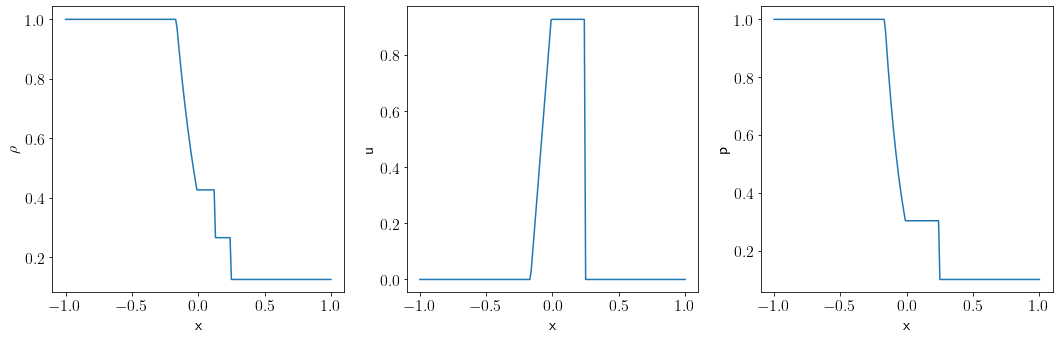

In [20]:
p_L, u_L, r_L, p_R, u_R, r_R = [1, 0, 1, 0.1, 0, 0.125] # case 1
#p_L, u_L, r_L, p_R, u_R, r_R = [1, 3, 1, 0.2, -1, 0.1]  # case 2
#p_L, u_L, r_L, p_R, u_R, r_R = [1, -2, 1, 0.2, 2, 0.4]  # case 3
#p_L, u_L, r_L, p_R, u_R, r_R = [0.1, 0, 0.125, 1, 0, 1]  # case 4
#p_L, u_L, r_L, p_R, u_R, r_R = [0.2, -8, 1, 0.3, 6, 0.1]  # case 5
gamma = 1.4

print('===========Exact Riemann Solver, Python Version===========\n')
nx = 201 # grid number for plot
t = 0.14 # time

r, u, p, x = Riemann_exact_solver(p_L, u_L, r_L, p_R, u_R, r_R, gamma, nx, t)
fig = plt.figure(figsize=(15,5)); 
ax = fig.add_subplot(131)
plt.plot(x, r); plt.xlabel('x'); plt.ylabel(r'$\rho$'); 
ax = fig.add_subplot(132)
plt.plot(x, u); plt.xlabel('x'); plt.ylabel('u')
ax = fig.add_subplot(133)
plt.plot(x, p); plt.xlabel('x'); plt.ylabel('p')
plt.tight_layout()
plt.rcParams.update({'font.size': 16})

In [40]:
a = np.array([1, 2, 3])
b = np.array([4, 5, 6])

array([0.25, 0.4 , 0.5 ])